In [1]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Define file paths in Google Drive
normal_data_path = '/content/drive/My Drive/ptbdb_normal.csv'
abnormal_data_path = '/content/drive/My Drive/ptbdb_abnormal.csv'

# Load data
normal_data = pd.read_csv(normal_data_path, header=None)
abnormal_data = pd.read_csv(abnormal_data_path, header=None)

# Check data loaded
print("Normal data shape:", normal_data.shape)
print("Abnormal data shape:", abnormal_data.shape)


Mounted at /content/drive
Normal data shape: (4046, 188)
Abnormal data shape: (10506, 188)


✔️ No overlap between training and test sets.
Epoch 1/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 36s 114ms/step - accuracy: 0.7580 - loss: 0.5089 - val_accuracy: 0.7236 - val_loss: 1.3336 - learning_rate: 5.0000e-04
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.8506 - loss: 0.3606 - val_accuracy: 0.7305 - val_loss: 1.1311 - learning_rate: 5.0000e-04
Epoch 3/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8308 - loss: 0.4083 - val_accuracy: 0.8616 - val_loss: 0.3360 - learning_rate: 5.0000e-04
Epoch 4/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8750 - loss: 0.2998 - val_accuracy: 0.8889 - val_loss: 0.2702 - learning_rate: 5.0000e-04
Epoch 5/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8873 - loss: 0.2809 - val_accuracy: 0.8902 - val_loss: 0.2645 - learning_rate: 5.0000e-04
Epoch 6/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.8906 - loss: 0.2838 - val_accuracy: 0.9065 - val_loss: 0.2417 - learning_rate: 5.0000e-04
Epoch 7/5

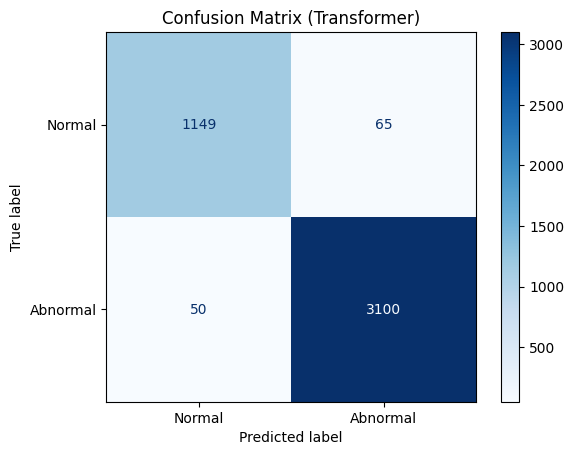

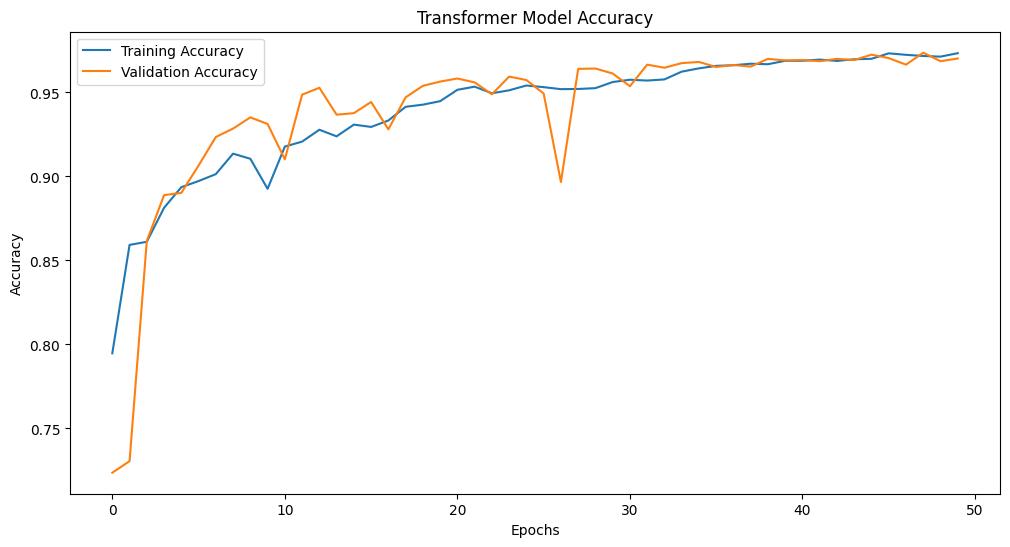

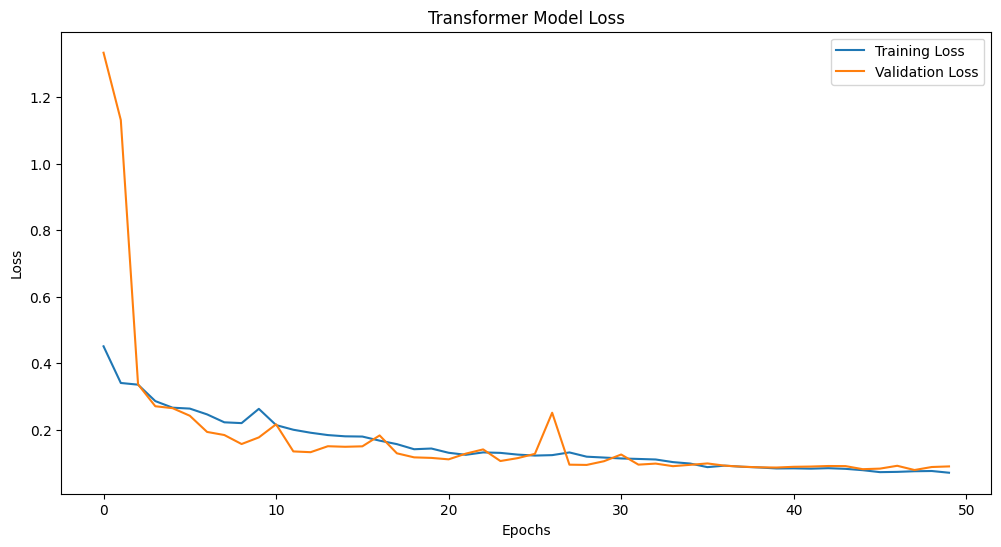

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# # Load Data (replace with your actual file paths)
# normal_data = pd.read_csv('/content/drive/My Drive/data/ptbdb_normal.csv', header=None)
# abnormal_data = pd.read_csv('/content/drive/My Drive/data/ptbdb_abnormal.csv', header=None)

# Remove the last column
normal_data = normal_data.drop(columns=[normal_data.columns[-1]])
abnormal_data = abnormal_data.drop(columns=[abnormal_data.columns[-1]])

# Add labels
normal_data['label'] = 0
abnormal_data['label'] = 1

# Combine data
data = pd.concat([normal_data, abnormal_data], axis=0).reset_index(drop=True)

# Remove duplicate samples
data = data.drop_duplicates()

# Shuffle data
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Split features and labels
X = data.iloc[:, :-1].values
y = data['label'].values

# Define a function to check for overlap
def check_overlap(X_train, X_test):
    train_flat = set(map(tuple, X_train))
    test_flat = set(map(tuple, X_test))
    overlap = train_flat.intersection(test_flat)
    if overlap:
        print(f"Warning: Found {len(overlap)} overlapping samples between training and test sets!")
    else:
        print("\u2714\ufe0f No overlap between training and test sets.")
    
    train_classes, train_counts = np.unique(y_train, return_counts=True)
    print("\nClass distribution in Training set:")
    for cls, count in zip(train_classes, train_counts):
        print(f"Class {cls}: {count} samples")

    test_classes, test_counts = np.unique(y_test, return_counts=True)
    print("\nClass distribution in Test set:")
    for cls, count in zip(test_classes, test_counts):
        print(f"Class {cls}: {count} samples")

    train_distribution = train_counts / len(y_train)
    test_distribution = test_counts / len(y_test)
    if np.allclose(train_distribution, test_distribution, atol=0.05):
        print("\n\u2714\ufe0f Class distribution between Train and Test sets is similar.")
    else:
        print("\nWarning: Class distribution between Train and Test sets differs significantly!")

# Define a function to split data by time and avoid overlap
def split_data_temporally(X, y, train_ratio=0.8):
    train_size = int(len(X) * train_ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return X_train, X_test, y_train, y_test

# Split data temporally
X_train, X_test, y_train, y_test = split_data_temporally(X, y)

# Normalize data separately for training and testing
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply Fourier Transform (optional)
def apply_fourier_transform(data):
    return np.abs(np.fft.fft(data, axis=1))

X_train = apply_fourier_transform(X_train)
X_test = apply_fourier_transform(X_test)

# Check for overlap
check_overlap(X_train, X_test)

# Add noise to training data (optional)
def add_noise(data, noise_level=0.05):
    noise = noise_level * np.random.normal(size=data.shape)
    return data + noise

X_train = add_noise(X_train, noise_level=0.05)

# Reshape for Transformer input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define Transformer Encoder Block
def transformer_encoder(inputs, num_heads, ff_dim, dropout=0.1):
    attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention = tf.keras.layers.Dropout(dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    ff = tf.keras.layers.Dense(ff_dim, activation='relu')(attention)
    ff = tf.keras.layers.Dense(inputs.shape[-1])(ff)
    ff = tf.keras.layers.Dropout(dropout)(ff)
    return tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + ff)

# Build Transformer-based Model
def build_transformer_model(input_shape):
    input_layer = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu')(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = transformer_encoder(x, num_heads=4, ff_dim=256)
    x = transformer_encoder(x, num_heads=4, ff_dim=256)
    x = transformer_encoder(x, num_heads=4, ff_dim=256)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

# Build and compile model
model = build_transformer_model(input_shape=(X_train.shape[1], X_train.shape[2]))
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)
    ],
    verbose=1
)

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Classification report and confusion matrix
y_pred = (model.predict(X_test) > 0.5).astype(int)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()


Epoch 1/20
685/685 ━━━━━━━━━━━━━━━━━━━━ 48s 40ms/step - accuracy: 0.8702 - loss: 0.4552 - val_accuracy: 0.9036 - val_loss: 0.2841 - learning_rate: 0.0010
Epoch 2/20
685/685 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.9111 - loss: 0.2882 - val_accuracy: 0.9187 - val_loss: 0.2670 - learning_rate: 0.0010
Epoch 3/20
685/685 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.9176 - loss: 0.2652 - val_accuracy: 0.9199 - val_loss: 0.2534 - learning_rate: 0.0010
Epoch 4/20
685/685 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.9219 - loss: 0.2617 - val_accuracy: 0.6786 - val_loss: 0.6993 - learning_rate: 0.0010
Epoch 5/20
685/685 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.9158 - loss: 0.2640 - val_accuracy: 0.9345 - val_loss: 0.2222 - learning_rate: 0.0010
Epoch 6/20
685/685 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.9279 - loss: 0.2413 - val_accuracy: 0.9006 - val_loss: 0.2872 - learning_rate: 0.0010
Epoch 7/20
685/685 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.9205 - l

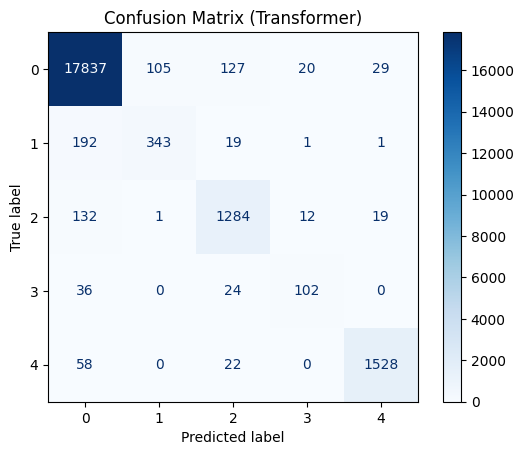

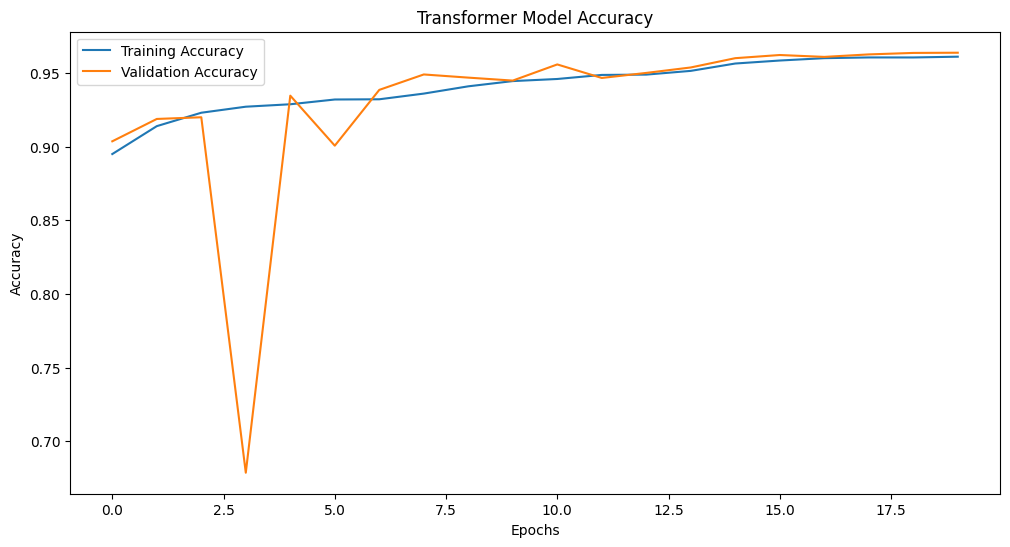

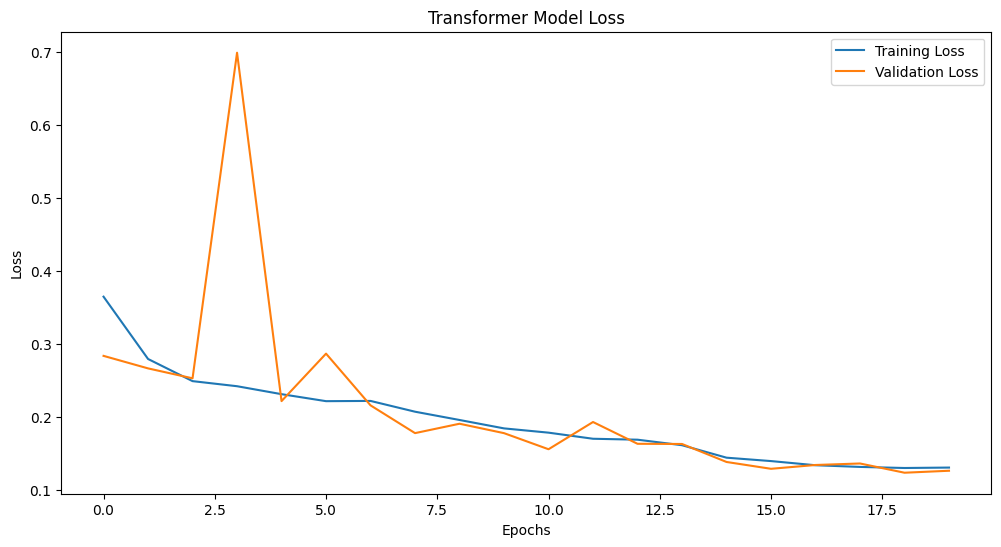

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical

# Load data
train_data = pd.read_csv('/content/drive/My Drive/mitbih_train.csv', header=None)
test_data = pd.read_csv('/content/drive/My Drive/mitbih_test.csv', header=None)

# Separate features and labels
X_train = train_data.iloc[:, :-1].values
y_train = train_data.iloc[:, -1].values  # Labels are in the last column
X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values

# Check for invalid or missing labels
def clean_labels(features, labels):
    """Ensure all features and labels have matching lengths and valid data."""
    valid_indices = ~np.isnan(labels)  # Remove NaN values
    features = features[valid_indices]
    labels = labels[valid_indices].astype(int)  # Convert to integers
    return features, labels

X_train, y_train = clean_labels(X_train, y_train)
X_test, y_test = clean_labels(X_test, y_test)

# Normalize data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# One-hot encode labels for multi-class classification
y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

# Apply Fourier Transform (optional for feature extraction)
def apply_fourier_transform(data):
    return np.abs(np.fft.fft(data, axis=1))

X_train = apply_fourier_transform(X_train)
X_test = apply_fourier_transform(X_test)

# Reshape for Transformer input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define Transformer Encoder Block
def transformer_encoder(inputs, num_heads, ff_dim, dropout=0.1):
    attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention = tf.keras.layers.Dropout(dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    ff = tf.keras.layers.Dense(ff_dim, activation='relu')(attention)
    ff = tf.keras.layers.Dense(inputs.shape[-1])(ff)
    ff = tf.keras.layers.Dropout(dropout)(ff)
    return tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + ff)

# Build Transformer-based Model
input_layer = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))

x = tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.Dropout(0.3)(x)

x = transformer_encoder(x, num_heads=2, ff_dim=128)
x = transformer_encoder(x, num_heads=2, ff_dim=128)
x = transformer_encoder(x, num_heads=2, ff_dim=128)

x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
output_layer = tf.keras.layers.Dense(5, activation='softmax')(x)

model_transformer = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile model
model_transformer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
history_transformer = model_transformer.fit(
    X_train, y_train,
    epochs=20,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    ]
)

# Evaluate model
loss_transformer, accuracy_transformer = model_transformer.evaluate(X_test, y_test)
print(f'Test Accuracy with Transformer: {accuracy_transformer * 100:.2f}%')

# Predictions and confusion matrix
y_pred_transformer = model_transformer.predict(X_test)
y_pred_classes = np.argmax(y_pred_transformer, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\nClassification Report (Transformer):")
print(classification_report(y_true_classes, y_pred_classes))
# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
unique_classes = np.unique(np.concatenate((y_true_classes, y_pred_classes)))  # Dynamically determine unique classes
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Transformer)")
plt.show()

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_transformer.history['accuracy'], label='Training Accuracy')
plt.plot(history_transformer.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Transformer Model Accuracy')
plt.show()

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(history_transformer.history['loss'], label='Training Loss')
plt.plot(history_transformer.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Transformer Model Loss')
plt.show()
